Feb 21

The OWER classifier does learn something - training loss decreases
 as does validation until the 5th epoch or so - but
validation loss decreases only slightly, and the results on
"Barack Obama is a married, male, American actor" look bad.

It is worth turning the weights of the loss function but still the
resulting classes for Obama differ randomly from run to run. Also,
plotting the class/word attentions shows that those converge, but
the observable correlations are not as expected.

In the following a minimal example shall be constructed to proof
the concept behind the classifier. An entity with a few short
sentences from a small vocabulary shall be forwarded through a
pre-trained OWER classifier whose class embeddings perfectly match
the sentences so that the correct classes should be predicted.

Example scenario:

```
Input sentences: "married married", "male male", "american american"
Expected classes: married=True, male=True, american=True, actor=?
```

### Helper

In [3]:
def log_tensor(_tensor, _title, _labels):
    pass

%run util.ipynb

foo


### Input

Given an input such as `raw_input` in the following, pre-processing
should yield a `sents_batch` and a `classes_batch`, each of size 1.

In [2]:
raw_input = {
    'ent': 123,
    'classes': [1, 1, 1, 0],  # classes = married, male, american, actor
    'sents': [
        'married married married',
        'male male male',
        'American American American'
    ]
}

import torch

sents_batch = torch.tensor([[
    [1, 1, 1],
    [2, 2, 2],
    [3, 3, 3]
]])

classes_batch = torch.tensor([[1, 1, 1, 0]])

batch_size = 1
sent_count = 3
sent_len = 3

### Prepare EmbeddingBag

Prepare an `EmbeddingBag` for 4 tokens:
- 0 = unknown
- 1 = 'married'
- 2 = 'male'
- 3 = 'American'

In [3]:
from torch.nn import EmbeddingBag
from torch import tensor

embedding_bag = EmbeddingBag(num_embeddings=4, embedding_dim=4)

embedding_bag.weight.data = tensor([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.]
])

print(embedding_bag)
print(embedding_bag.weight)

EmbeddingBag(4, 4, mode=mean)
Parameter containing:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], requires_grad=True)


### Prepare class embeddings

Prepare class embeddings for the 4 classes. Class embeddings 1-3 perfectly
match tokens 1-3. Class embedding 0 doesn't match any token.

In [4]:
class_embs = tensor([
    [0., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.]
])

print(class_embs)

tensor([[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


### Prepare linear layer

Prepare the final linear layer whose weights are set so that it
completely relies on "class 0 sentence mix" for output class 0,
"class 1 sentence mix" for output class 1, etc.

In [5]:
from torch.nn import Linear

class_count = 4
emb_size = 4

linear = Linear(class_count * emb_size, class_count)

linear.weight.data = tensor([
    [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]
])

linear.bias.data = tensor([0., 0., 0., 0.])

In [6]:
ent_labels = [f'ent {i}' for i in range(batch_size)]
class_labels = ['married', 'male', 'American', 'actor']
tok_labels = [f'tok {i}' for i in range(sent_len)]
sent_labels = [f'sent {i}' for i in range(sent_count)]
emb_labels = [f'emb {i}' for i in range(emb_size)]

### Forward

#### 1.1 Embed Sentences

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])


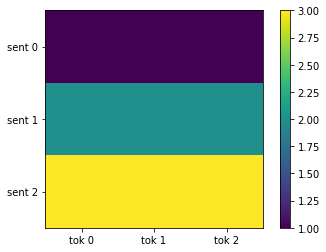

In [7]:
#
# Flatten batch
#
# < sents_batch     (batch_size, sent_count, sent_len)
# > flat_sents      (batch_size * sent_count, sent_len)
#

flat_sents = sents_batch.reshape(batch_size * sent_count, sent_len)

log_tensor(flat_sents, 'flat_sents',
           [batch_size * sent_labels, tok_labels])

tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<EmbeddingBagBackward>)


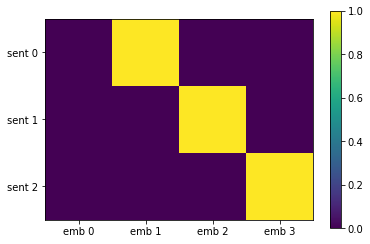

In [8]:
#
# Embed sentences
#
# < flat_sents      (batch_size * sent_count, sent_len)
# > flat_sent_embs  (batch_size * sent_count, emb_size)
#

flat_sent_embs = embedding_bag(flat_sents)

log_tensor(flat_sent_embs, 'flat_sent_embs',
           [batch_size * sent_labels, emb_labels])

tensor([[[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<ViewBackward>)


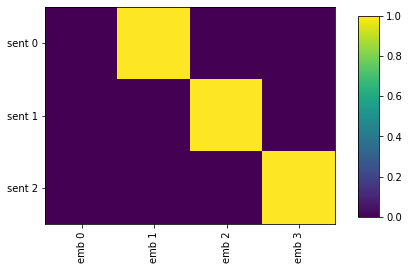

In [9]:
#
# Restore batch
#
# < flat_sent_embs      (batch_size * sent_count, emb_size)
# > sent_embs_batch     (batch_size, sent_count, emb_size)
#

sent_embs_batch = flat_sent_embs.reshape(batch_size, sent_count, emb_size)

log_tensor(sent_embs_batch, 'sent_embs_batch',
           [ent_labels, sent_labels, emb_labels])

#### 1.2 Calc attentions

tensor([[[0., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])


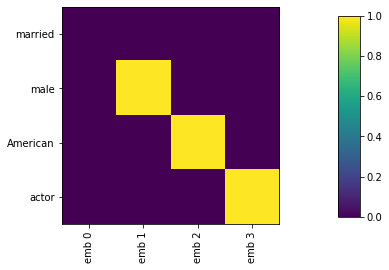

In [10]:
#
# Expand class embeddings for bmm()
#
# < class_embs          (class_count, emb_size)
# > class_embs_batch    (batch_size, class_count, emb_size)
#

class_embs_batch = class_embs.expand(batch_size, class_count, emb_size)

log_tensor(class_embs_batch, 'class_embs_batch',
           [ent_labels, class_labels, emb_labels])

tensor([[[0., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], grad_fn=<BmmBackward0>)


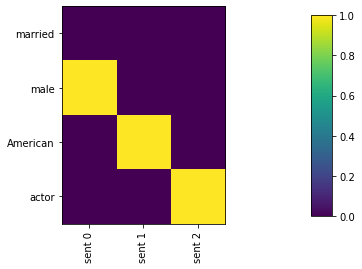

In [11]:
#
# Multiply each class with each sentence
#
# < class_embs_batch    (batch_size, class_count, emb_size)
# < sent_embs_batch     (batch_size, sent_count, emb_size)
# > atts_batch          (batch_size, class_count, sent_count)
#

atts_batch = torch.bmm(class_embs_batch, sent_embs_batch.transpose(1, 2))

log_tensor(atts_batch, 'atts_batch',
           [ent_labels, class_labels, sent_labels])

tensor([[[0.3333, 0.3333, 0.3333],
         [0.5761, 0.2119, 0.2119],
         [0.2119, 0.5761, 0.2119],
         [0.2119, 0.2119, 0.5761]]], grad_fn=<SoftmaxBackward>)


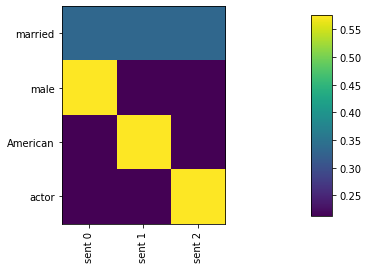

In [12]:
#
# Apply softmax over sentences
#
# < atts_batch      (batch_size, class_count, sent_count)
# > softs_batch     (batch_size, class_count, sent_count)
#

from torch.nn import Softmax

softs_batch = Softmax(dim=-1)(atts_batch)

log_tensor(softs_batch, 'softs_batch',
           [ent_labels, class_labels, sent_labels])

#### 1.3 Weight sentences

tensor([[[[0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]],

         [[0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]],

         [[0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]],

         [[0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]]]], grad_fn=<ExpandBackward>)


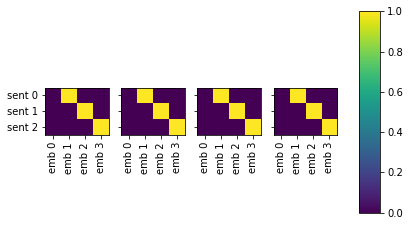

In [13]:
#
# Repeat each batch slice class_count times
#
# < sent_embs_batch     (batch_size, sent_count, emb_size)
# > expaned_batch       (batch_size, class_count, sent_count, emb_size)
#

expaned_batch = sent_embs_batch.unsqueeze(1).expand(-1, class_count, -1, -1)

log_tensor(expaned_batch, 'expaned_batch',
           [ent_labels, class_labels, sent_labels, emb_labels])

tensor([[[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<ViewBackward>)


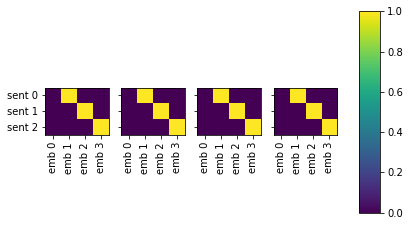

In [14]:
#
# Flatten sentences for bmm()
#
# < expaned_batch   (batch_size, class_count, sent_count, emb_size)
# > flat_expanded   (batch_size * class_count, sent_count, emb_size)
#

flat_expanded = expaned_batch.reshape(-1, sent_count, emb_size)

log_tensor(flat_expanded, 'flat_expanded',
           [batch_size * class_labels, sent_labels, emb_labels])

tensor([[[0.3333],
         [0.3333],
         [0.3333]],

        [[0.5761],
         [0.2119],
         [0.2119]],

        [[0.2119],
         [0.5761],
         [0.2119]],

        [[0.2119],
         [0.2119],
         [0.5761]]], grad_fn=<UnsqueezeBackward0>)


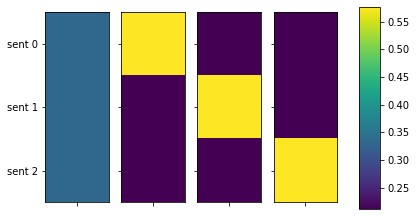

In [15]:
#
# Flatten attentions for bmm()
#
# < softs_batch     (batch_size, class_count, sent_count)
# > flat_softs      (batch_size * class_count, sent_count, 1)
#

flat_softs = softs_batch.reshape(batch_size * class_count, sent_count).unsqueeze(-1)

log_tensor(flat_softs, 'flat_softs',
           [batch_size * class_labels, sent_labels, ['']])

tensor([[0.0000, 0.3333, 0.3333, 0.3333],
        [0.0000, 0.5761, 0.2119, 0.2119],
        [0.0000, 0.2119, 0.5761, 0.2119],
        [0.0000, 0.2119, 0.2119, 0.5761]], grad_fn=<SqueezeBackward1>)


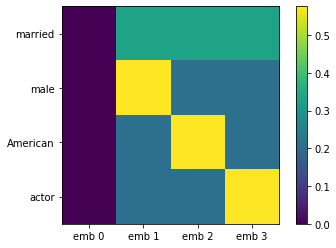

In [16]:
#
# Multiply each sentence with each attention
#
# < flat_expanded   (batch_size * class_count, sent_count, emb_size)
# < flat_softs      (batch_size * class_count, sent_count, 1)
# > flat_weighted   (batch_size * class_count, emb_size)
#

flat_weighted = torch.bmm(flat_expanded.transpose(1, 2), flat_softs).squeeze(-1)

log_tensor(flat_weighted, 'flat_weighted',
           [batch_size * class_labels, emb_labels])

tensor([[[0.0000, 0.3333, 0.3333, 0.3333],
         [0.0000, 0.5761, 0.2119, 0.2119],
         [0.0000, 0.2119, 0.5761, 0.2119],
         [0.0000, 0.2119, 0.2119, 0.5761]]], grad_fn=<ViewBackward>)
tensor([[1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<AddmmBackward>)


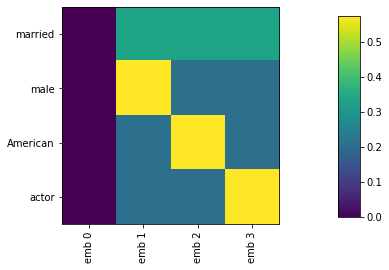

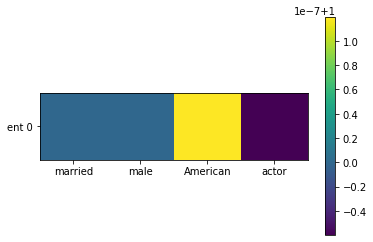

In [17]:
#
# Restore batch
#
# < flat_weighted   (batch_size * class_count, emb_size)
# > weighted_batch  (batch_size, class_count, emb_size)
#

weighted_batch = flat_weighted.reshape(batch_size, class_count, emb_size)

log_tensor(weighted_batch, 'weighted_batch',
           [ent_labels, class_labels, emb_labels])

inputs_batch = weighted_batch.reshape(batch_size, class_count * emb_size)
outputs_batch = linear(inputs_batch)

log_tensor(outputs_batch, 'outputs_batch',
           [ent_labels, class_labels])

tensor([[-5.3788, -5.3788, -5.3788,  0.1828]])
tensor([[[-5.3788, -5.3788, -5.3788, -5.3788],
         [-5.3788, -5.3788, -5.3788, -5.3788],
         [-5.3788, -5.3788, -5.3788, -5.3788],
         [ 0.1828,  0.1828,  0.1828,  0.1828]]])
tensor([[-5.3788, -5.3788, -5.3788, -5.3788],
        [-5.3788, -5.3788, -5.3788, -5.3788],
        [-5.3788, -5.3788, -5.3788, -5.3788],
        [ 0.1828,  0.1828,  0.1828,  0.1828]])
tensor([[[-5.3788],
         [-5.3788],
         [-5.3788]],

        [[-5.3788],
         [-5.3788],
         [-5.3788]],

        [[-5.3788],
         [-5.3788],
         [-5.3788]],

        [[ 0.1828],
         [ 0.1828],
         [ 0.1828]]])
tensor([[[-1.7929, -1.7929, -1.7929, -1.7929],
         [-1.7929, -1.7929, -1.7929, -1.7929],
         [-1.7929, -1.7929, -1.7929, -1.7929]],

        [[-3.0988, -3.0988, -3.0988, -3.0988],
         [-1.1400, -1.1400, -1.1400, -1.1400],
         [-1.1400, -1.1400, -1.1400, -1.1400]],

        [[-1.1400, -1.1400, -1.1400, -1.1400

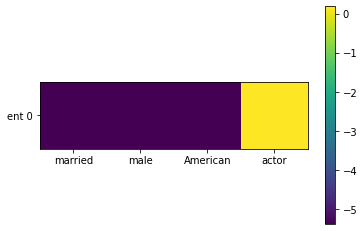

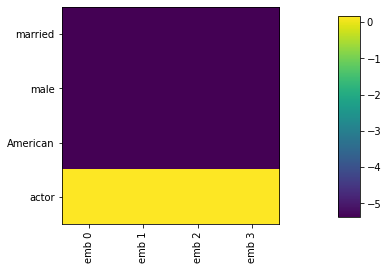

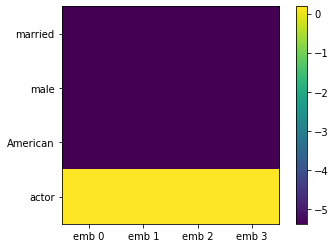

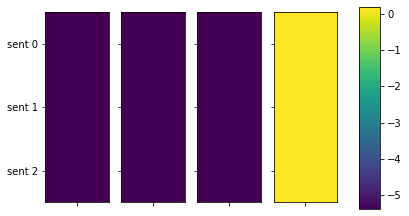

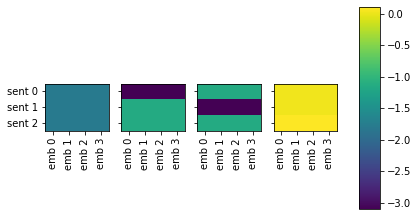

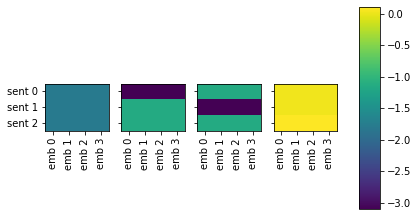

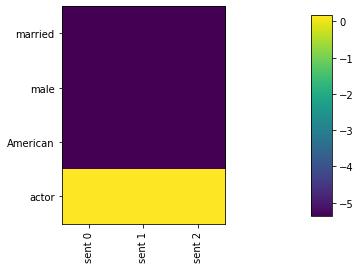

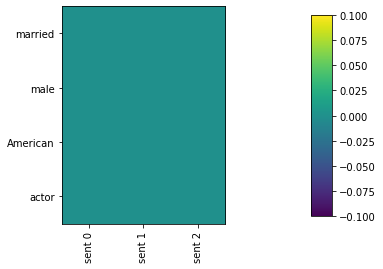

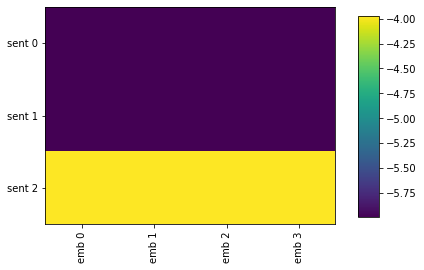

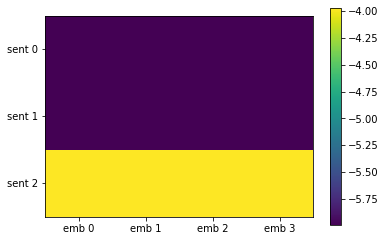

In [18]:
from torch.nn import BCEWithLogitsLoss

criterion = BCEWithLogitsLoss(pos_weight=torch.tensor([80] * class_count))

loss = criterion(outputs_batch, classes_batch.float())
loss.backward()